# Libraries

In [1]:
import numpy as np
import pandas as pd
from PIL import Image

In [63]:
# def read_files (path):
#     df = pd.read_csv (path) [['Path', 'ClassId']]
#     unique_classes = df ['ClassId'].unique ()
#     selected_classes = np.random.choice (unique_classes, size=8, replace=False)

#     selected_data = pd.DataFrame ()
#     for class_id in selected_classes:
#         class_images = df [df ['ClassId'] == class_id].sample (n=100)
#         selected_data = pd.concat ([selected_data, class_images], ignore_index=True)

#     selected_data = selected_data.sample(frac=1, random_state=42).reset_index(drop=True)
#     selected_data = selected_data.sort_values(by=['ClassId', 'Path']).reset_index(drop=True)

#     return selected_data

# read_files ("Train.csv").to_csv ("train_use.csv", index=False)

# Clip Function

In [64]:
def clip (image):
    image [image < 0] = 0
    image [image > 255] = 255

    return image.astype (np.uint8)

# Preprocessing and Filtering

In [65]:
def mean_filter (image):
    image = image.astype (np.float32)
    padded = np.pad (image, ((1,1),(1,1)), mode = 'edge')
    output = np.zeros_like (image)

    for i in range (image.shape [0]):
        for j in range (image.shape [1]):
            region = padded [i:i+3, j:j+3]
            output [i, j] = np.mean (region)

    return clip (output).astype (np.uint8)

In [66]:
def gaussian_kernel ():
    sigma = 1
    size = 3

    ax = np.linspace (-(size // 2), size // 2, size)
    xx, yy = np.meshgrid (ax, ax)
    kernel = np.exp (-(xx ** 2 + yy ** 2) / (2 * sigma ** 2))
    kernel /= (2 * np.pi * sigma ** 2)
    kernel /= np.sum (kernel)
    return kernel

def gaussian_filter (image):
    image = image.astype (np.float32)
    kernel = gaussian_kernel ()

    a, b = image.shape
    output = np.zeros_like (image)

    for i in range (a):
        for j in range (b):
            sum = 0
            for k in range (3):
                for l in range (3):
                    x = i + k - 1
                    y = j + l - 1

                    if 0 <= x < a and 0 <= y < b:
                        sum += image [x, y] * kernel [k, l]
            output [i, j] = sum

    return clip (output).astype (np.uint8)

In [67]:
def median_filter (image):
    image = image.astype (np.float32)
    padded = np.pad (image, ((1,1), (1,1)), mode='edge')
    output = np.zeros_like (image)

    for i in range (image.shape [0]):
        for j in range (image.shape [1]):
            region = padded [i : i+3, j : j+3]
            output [i, j] = np.median (region)

    return clip (output).astype (np.uint8)

In [68]:
def adaptive_median_filter (image, max_size=7):
    image = image.astype (np.float32)
    output = image.copy ()
    pad = max_size // 2
    padded = np.pad (image, pad, mode='edge')

    for i in range (image.shape[0]):
        for j in range (image.shape[1]):
            window_size = 3
            while window_size <= max_size:
                half = window_size // 2
                region = padded [i + pad - half : i + pad + half + 1,
                                j + pad - half : j + pad + half + 1]
                z_min = np.min (region)
                z_max = np.max (region)
                z_med = np.median (region)
                z_xy = padded [i + pad, j + pad]

                A1 = z_med - z_min
                A2 = z_med - z_max

                if A1 > 0 and A2 < 0:
                    B1 = z_xy - z_min
                    B2 = z_xy - z_max
                    if B1 > 0 and B2 < 0:
                        output [i, j] = z_xy
                    else:
                        output [i, j] = z_med
                    break
                else:
                    window_size += 2

            if window_size > max_size:
                output [i, j] = z_med

    return clip (output).astype (np.uint8)


In [69]:
def high_boost_filter (image, A=1.5):
    image = image.astype (np.float32)
    blurred = gaussian_filter (image)
    mask = image - blurred
    output = (A - 1) * image + mask
    return clip (output).astype (np.uint8)

# Color Space Conversion and Segmentation

In [70]:
def rgb_to_hsv (image):
    image = image.astype (np.float32) / 255.0
    r, g, b = image [..., 0], image [..., 1], image [..., 2]
    c_max = np.max (image, axis=2)
    c_min = np.min (image, axis=2)
    delta = c_max - c_min

    h = np.zeros_like (c_max)
    s = np.zeros_like (c_max)
    v = c_max

    mask = delta != 0
    r_mask = (c_max == r) & mask
    g_mask = (c_max == g) & mask
    b_mask = (c_max == b) & mask

    h [r_mask] = (60 * (g [r_mask] - b [r_mask]) / delta [r_mask]) % 360
    h [g_mask] = (60 * (b [g_mask] - r [g_mask]) / delta [g_mask]) + 120
    h [b_mask] = (60 * (r [b_mask] - g [b_mask]) / delta [b_mask]) + 240

    h [~mask] = 0
    s [c_max != 0] = delta [c_max != 0] / c_max [c_max != 0]
    s [c_max == 0] = 0

    hsv = np.stack ([h, s, v], axis=2)
    return hsv


In [25]:
def segment_red_blue (hsv):
    h, s, v = hsv [..., 0], hsv [..., 1], hsv [..., 2]

    red_mask1 = (h >= 0) & (h <= 15) & (s >= 100/255.0) & (v >= 80/255.0)
    red_mask2 = (h >= 165) & (h <= 180) & (s >= 0.4) & (v >= 0.3)
    red_mask = red_mask1 | red_mask2

    blue_mask = (h >= 100) & (h <= 130) & (s >= 0.4) & (v >= 0.3)

    mask = red_mask | blue_mask
    return (mask * 255).astype (np.uint8)


In [ ]:
def binary_threshold (image, threshold=127):
    binary = np.zeros_like (image, dtype=np.uint8)
    binary [image > threshold] = 255
    return binary

In [27]:
def erode (image, kernel_size=3):
    pad = kernel_size // 2
    padded = np.pad (image, pad, mode='edge')
    output = np.zeros_like (image)

    for i in range (image.shape [0]):
        for j in range (image.shape [1]):
            region = padded [i:i+kernel_size, j:j+kernel_size]
            output [i, j] = np.min (region)
    return output

def dilate (image, kernel_size=3):
    pad = kernel_size // 2
    padded = np.pad (image, pad, mode='edge')
    output = np.zeros_like (image)

    for i in range (image.shape [0]):
        for j in range (image.shape [1]):
            region = padded [i:i+kernel_size, j:j+kernel_size]
            output [i, j] = np.max (region)
    return output

def opening (image, kernel_size=3):
    return dilate (erode (image, kernel_size), kernel_size)


In [28]:
def connected_component_filtering (binary_image, area_threshold=300):
    h, w = binary_image.shape
    labels = np.zeros_like (binary_image, dtype=np.int32)
    output = np.zeros_like (binary_image)
    label = 1

    for i in range (h):
        for j in range (w):
            if binary_image [i, j] == 255 and labels [i, j] == 0:
                stack = [(i, j)]
                component = []

                while stack:
                    x, y = stack.pop ()
                    if (0 <= x < h) and (0 <= y < w):
                        if binary_image [x, y] == 255 and labels [x, y] == 0:
                            labels [x, y] = label
                            component.append ((x, y))
                            stack.extend ([(x+1,y), (x-1,y), (x,y+1), (x,y-1)])

                if len (component) >= area_threshold:
                    for (x, y) in component:
                        output [x, y] = 255

                label += 1

    return output


In [29]:
def fill_holes (binary_image):
    h, w = binary_image.shape
    visited = np.zeros_like (binary_image, dtype=bool)
    filled = binary_image.copy ()

    stack = []
    for i in range (h):
        if filled [i, 0] == 0:
            stack.append ((i, 0))
        if filled [i, w - 1] == 0:
            stack.append ((i, w - 1))
    for j in range (w):
        if filled [0, j] == 0:
            stack.append ((0, j))
        if filled [h - 1, j] == 0:
            stack.append ((h - 1, j))

    while stack:
        x, y = stack.pop ()
        if 0 <= x < h and 0 <= y < w:
            if filled [x, y] == 0 and not visited[x, y]:
                visited [x, y] = True
                stack.extend ([(x+1,y), (x-1,y), (x,y+1), (x,y-1)])

    for i in range (h):
        for j in range (w):
            if not visited [i, j] and filled [i, j] == 0:
                filled [i, j] = 255

    return filled


# Edge Detection

In [30]:
def sobel_gradients (image):

    Kx = np.array ([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], dtype=np.float32)
    Ky = np.array ([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]], dtype=np.float32)

    pad = 1
    padded = np.pad (image, pad, mode='reflect')
    Gx = np.zeros_like (image, dtype=np.float32)
    Gy = np.zeros_like (image, dtype=np.float32)

    for i in range (image.shape[0]):
        for j in range (image.shape[1]):
            region = padded [i:i+3, j:j+3]
            Gx [i, j] = np.sum (region * Kx)
            Gy [i, j] = np.sum (region * Ky)

    magnitude = np.sqrt (Gx**2 + Gy**2)
    direction = np.arctan2 (Gy, Gx)
    
    return magnitude, direction

In [31]:
def non_max_suppression (magnitude, direction):
    h, w = magnitude.shape
    output = np.zeros ((h, w), dtype=np.float32)
    angle = np.rad2deg (direction) % 180

    for i in range (1, h-1):
        for j in range (1, w-1):
            q, r = 255, 255

            if (0 <= angle [i,j] < 22.5) or (157.5 <= angle [i,j] <= 180):
                q = magnitude [i, j+1]
                r = magnitude [i, j-1]

            elif 22.5 <= angle [i,j] < 67.5:
                q = magnitude [i+1, j-1]
                r = magnitude [i-1, j+1]
            
            elif 67.5 <= angle [i,j] < 112.5:
                q = magnitude [i+1, j]
                r = magnitude [i-1, j]
            
            elif 112.5 <= angle [i,j] < 157.5:
                q = magnitude [i-1, j-1]
                r = magnitude [i+1, j+1]

            if magnitude [i,j] >= q and magnitude [i,j] >= r:
                output [i,j] = magnitude [i,j]
            else:
                output [i,j] = 0

    return output

In [32]:
def double_thresholding (img, low_thresh_ratio=0.05, high_thresh_ratio=0.15):
    high_thresh = img.max () * high_thresh_ratio
    low_thresh = high_thresh * low_thresh_ratio

    strong = 255
    weak = 75

    result = np.zeros_like (img, dtype=np.uint8)

    strong_i, strong_j = np.where (img >= high_thresh)
    weak_i, weak_j = np.where ((img <= high_thresh) & (img >= low_thresh))

    result [strong_i, strong_j] = strong
    result [weak_i, weak_j] = weak

    return result, weak, strong

In [33]:
def edge_tracking_by_hysteresis (img, weak, strong=255):
    h, w = img.shape
    for i in range (1, h-1):
        for j in range (1, w-1):
            if img [i,j] == weak:
                if ((img [i+1, j-1] == strong) or (img [i+1, j] == strong) or (img [i+1, j+1] == strong)
                    or (img [i, j-1] == strong) or (img [i, j+1] == strong)
                    or (img [i-1, j-1] == strong) or (img [i-1, j] == strong) or (img [i-1, j+1] == strong)):
                    img [i, j] = strong
                else:
                    img [i, j] = 0
    return img

# Geometric Normalization

In [34]:
def rotate_image (image, angle_deg):
    angle_rad = np.deg2rad (angle_deg)
    h, w = image.shape [:2]
    center = np.array ([w / 2, h / 2])

    R = np.array ([
        [np.cos (angle_rad), -np.sin (angle_rad)],
        [np.sin (angle_rad),  np.cos (angle_rad)]
    ])

    coords_y, coords_x = np.meshgrid (np.arange (h), np.arange (w), indexing='ij')
    coords = np.stack ([coords_x.ravel (), coords_y.ravel ()], axis=1)

    shifted = coords - center
    rotated = shifted @ R.T + center
    rotated = rotated.round ().astype (int)

    output = np.zeros_like (image)
    for i, (x_new, y_new) in enumerate (rotated):
        x_old, y_old = coords [i]
        if 0 <= y_new < h and 0 <= x_new < w:
            output [y_new, x_new] = image [y_old, x_old]
    return output

In [35]:
def scale_image (image, size=(200, 200)):
    h, w = image.shape [:2]
    new_h, new_w = size
    scale_y, scale_x = h / new_h, w / new_w

    y_indices = (np.arange (new_h) * scale_y).astype (int)
    x_indices = (np.arange (new_w) * scale_x).astype (int)
    
    return image [y_indices [:, None], x_indices]

In [36]:
def perspective_transform_numpy (image, src_pts, dst_pts, output_size=(200, 200)):
    
    def compute_homography (src, dst):
        A = []
        for (x, y), (u, v) in zip (src, dst):
            A.append ([-x, -y, -1, 0, 0, 0, x*u, y*u, u])
            A.append ([0, 0, 0, -x, -y, -1, x*v, y*v, v])
        A = np.array (A)
        _, _, Vt = np.linalg.svd (A)
        H = Vt [-1].reshape ((3, 3))
        return H / H [-1, -1]

    src = np.array (src_pts, dtype=np.float32)
    dst = np.array (dst_pts, dtype=np.float32)
    H = compute_homography (src, dst)

    output_h, output_w = output_size
    output = np.zeros ((output_h, output_w), dtype=image.dtype)

    for i in range (output_h):
        for j in range (output_w):
            target_coords = np.array ([j, i, 1])
            source_coords = np.linalg.inv (H) @ target_coords
            source_coords /= source_coords [2]
            x, y = int (round (source_coords [0])), int (round (source_coords [1]))
            if 0 <= y < image.shape [0] and 0 <= x < image.shape [1]:
                output [i, j] = image [y, x]

    return output

# Feature Extraction

In [37]:
def convolve2d (image, kernel):
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    padded = np.pad (image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    output = np.zeros_like (image, dtype=float)

    for i in range (image.shape [0]):
        for j in range (image.shape [1]):
            region = padded [i:i+kh, j:j+kw]
            output [i, j] = np.sum (region * kernel)
    return output

def harris_corner_count (gray, k=0.04, threshold_ratio=0.01):
    sobel_x = np.array ([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array ([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    Ix = convolve2d (gray, sobel_x)
    Iy = convolve2d (gray, sobel_y)

    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    kernel = np.array ([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16

    Sxx = convolve2d (Ixx, kernel)
    Syy = convolve2d (Iyy, kernel)
    Sxy = convolve2d (Ixy, kernel)

    detM = Sxx * Syy - Sxy ** 2
    traceM = Sxx + Syy
    R = detM - k * (traceM ** 2)

    threshold = threshold_ratio * np.max (R)
    corners = (R > threshold)
    return np.sum (corners)

def compute_perimeter (binary_mask):
    eroded = np.zeros_like (binary_mask)
    for i in range (1, binary_mask.shape [0]-1):
        for j in range (1, binary_mask.shape[1]-1):
            if binary_mask [i, j] == 1 and np.all (binary_mask [i-1:i+2, j-1:j+2] == 1):
                eroded [i, j] = 1
    perimeter = np.sum (binary_mask) - np.sum (eroded)
    return perimeter

def extract_features (normalized_rgb, binary_mask, normalized_hsv):
    gray = np.mean (normalized_rgb, axis=2).astype (np.float32)

    # 1. Corner Count
    corners = harris_corner_count (gray)

    # 2. Circularity
    area = np.sum (binary_mask)
    perimeter = compute_perimeter (binary_mask)
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

    # 3. Bounding box and Aspect Ratio
    ys, xs = np.where (binary_mask == 1)
    if len (xs) == 0 or len (ys) == 0:
        aspect_ratio = 0
        extent = 0
    else:
        width = xs.max () - xs.min () + 1
        height = ys.max () - ys.min () + 1
        aspect_ratio = width / height if height != 0 else 0

        # 4. Extent
        bbox_area = width * height
        extent = area / bbox_area if bbox_area != 0 else 0

    # 5. Average Hue
    hue = normalized_hsv [..., 0]
    avg_hue = np.mean (hue [binary_mask == 1]) if np.any (binary_mask == 1) else 0

    return {
        "corner_count": int (corners),
        "circularity": float (circularity),
        "aspect_ratio": float (aspect_ratio),
        "extent": float (extent),
        "average_hue": float (avg_hue)
    }


# Image Reading and Training

In [3]:
import pandas as pd
import os
from PIL import Image
import numpy as np

# Load CSV
df = pd.read_csv('dataset/Train.csv')

# Select N classes (example: 6 classes)
selected_classes = [0, 1, 2, 3, 4, 5, 6]
subset_df = df[df['ClassId'].isin(selected_classes)]


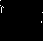

In [ ]:
image = Image.open ('00014.png')
gray = image.convert ('L')
arr = np.array (gray)

output = mean_filter (arr)
output = gaussian_filter (output)
output = median_filter (output)
output = adaptive_median_filter (output)
output = high_boost_filter (output)

Image.fromarray (output)

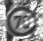

In [72]:
gray

In [ ]:
img_data = pd.read_csv ('train_use.csv')

for i in img_data ['Path']:
    image = Image.open (i)
    n = np.array (image)

(69, 68, 3)